In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import explode, split, regexp_replace
from pyspark.sql.types import StructType, StructField, StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# create a SparkSession
spark = SparkSession.builder.appName("TwitterStreaming").getOrCreate()

# create a StreamingContext with batch interval of 10 second
ssc = StreamingContext(spark.sparkContext, 10)
sqlContext = SQLContext(spark)
spark.sparkContext.setLogLevel("ERROR")

# create a DStream that reads data from port 5554
socket_stream = ssc.socketTextStream("127.0.0.1", 5554)
lines = socket_stream.window(20)


# define the schema for your DataFrame
schema = StructType([
    StructField("tweet", StringType(), True)
])

(lines.map(lambda x: x.split("t_end"))
 .flatMap(lambda x: x)
 .map(lambda x: x.strip())
 .filter(lambda x: len(x) > 0)
 .map(lambda x: re.sub(r'http\S+', '', x))
 .map(lambda x: re.sub(r'@\w+', '', x))
 .map(lambda x: re.sub(r'#', '', x))
 .map(lambda x: re.sub(r'RT', '', x))
 .map(lambda x: re.sub(r':', '', x))
 .foreachRDD(lambda rdd: rdd.map(lambda x: (x,)).toDF(schema).limit(25).createOrReplaceTempView("tweets_table"))
)

23/02/27 18:32:51 WARN Utils: Your hostname, Kaustubhs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.21 instead (on interface en0)
23/02/27 18:32:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/27 18:32:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
#Now run TweetRead.py before running the cell below

In [3]:
ssc.start()

In [4]:
#Load Libraries
import time
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline 

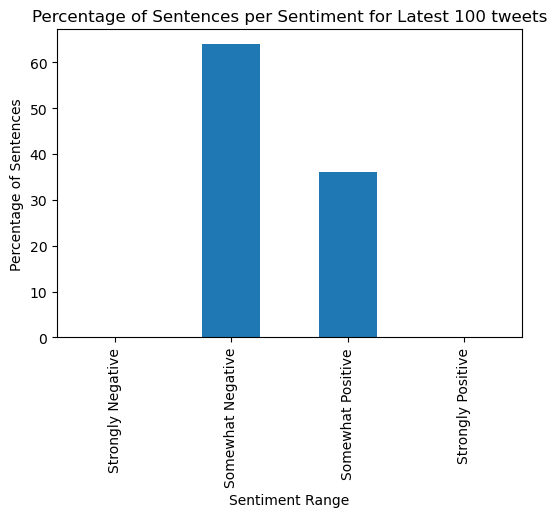

<Figure size 640x480 with 0 Axes>

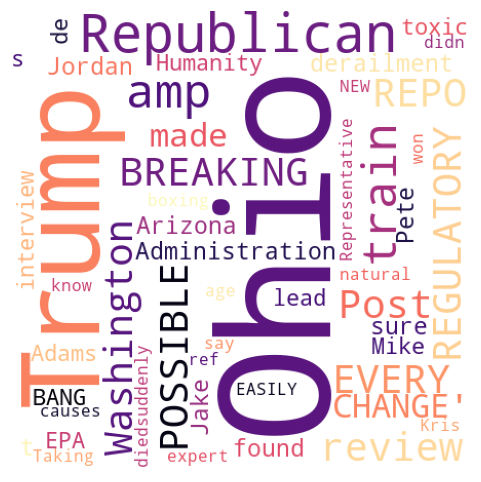

In [6]:
#Define function

# define a function to get sentiment polarity for each sentence
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

count = 0
prev_sentiment_percentages = pd.Series([0,0,0,0], index=['[-1.0, -0.5]', '(-0.5, 0.0]', '(0.0, 0.5]', '(0.5, 1.0]'])

while count < 5:
    display.clear_output(wait=True)
    time.sleep(5)
    latest_25 = sqlContext.sql('SELECT * FROM tweets_table LIMIT 25')
    sent_df = latest_25.toPandas()
    
    # apply the function to your dataframe to get sentiment for each sentence
    sent_df['sentiment'] = sent_df['tweet'].apply(get_sentiment)

    # group sentiment by range and count the number of sentences in each range
    bins = pd.cut(sent_df['sentiment'], bins=[-1, -0.5, 0, 0.5, 1])
    sentiment_counts = sent_df.groupby(bins)['sentiment'].count()

    # calculate percentage of sentences in each sentiment range
    sentiment_percentages = sentiment_counts / len(sent_df) * 100

    
    # plot the results with custom labels for each range
    plt.figure(figsize=(6,4))
    ax = sentiment_percentages.plot(kind='bar')
    ax.set_title('Sentiment Analysis Results')
    ax.set_xlabel('Sentiment Range')
    ax.set_ylabel('Percentage of Sentences')
    ax.set_xticklabels(['Strongly Negative', 'Somewhat Negative', 'Somewhat Positive', 'Strongly Positive'])

    #Calculate change from previous
    percentage_changes = ((sentiment_percentages - prev_sentiment_percentages) / prev_sentiment_percentages) * 100

    
    
    # add percentage change labels to each bar (STILL WORKING ON THIS)
#     for i, v in enumerate(sentiment_percentages):
#         ax.text(i - 0.1, v + 0.5, f'{v:.2f}%', fontsize=10)
#         if percentage_changes[i] > 0:
#             color = 'green'
#             sign = '+'
#         else:
#             color = 'red'
#             sign = ''
#         ax.text(i - 0.1, v - 5, f'{sign}{percentage_changes[i]:.2f}%', fontsize=10, color=color)



    plt.title('Percentage of Sentences per Sentiment for Latest 100 tweets')
    plt.show()
    
    # clear previous word cloud plot
    plt.clf()
    
    # display the word cloud
    plt.figure(figsize=(6,6))
    wordcloud = WordCloud(width=450, height=450, background_color='white', max_words=50, colormap='magma').generate_from_text(' '.join(sent_df['tweet']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    count += 1
    prev_sentiment_percentages = sentiment_percentages
    time.sleep(5)

In [7]:
# Stop the SparkSession. MAKE SURE TO RUN THIS AFTER YOU ARE DONE!!
ssc.stop()

23/02/27 18:35:42 ERROR ReceiverTracker: Deregistered receiver for stream 0: Stopped by driver
Exception in thread "receiver-supervisor-future-0" java.lang.Error: java.lang.InterruptedException: sleep interrupted
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1155)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.InterruptedException: sleep interrupted
	at java.lang.Thread.sleep(Native Method)
	at org.apache.spark.streaming.receiver.ReceiverSupervisor.$anonfun$restartReceiver$1(ReceiverSupervisor.scala:196)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:3